# Circuit Cellar - JTAG Example with ChipWhisperer

The following is using a ChipWhisperer-Husky, CW308 Target Board, with CW308T-MPC5676R target board.

You can see the [Target Board Documentation](https://github.com/newaetech/chipwhisperer-target-cw308t/tree/main/CW308T_MPC5Y) for information on the CW308T-MPC5676R target.

In [51]:
PLATFORM = ""
%run ../Setup_Scripts/Setup_Generic.ipynb

INFO: Found ChipWhisperer😍


Clock won't really matter, but normally this target uses 12 or 16 MHz. Set it to something round:

In [52]:
scope.clock.clkgen_freq = 16E6

The following should generate this output:
```
IR Length: 4
Found 1 devices
[136798237]
[{'manid': '00000001110', 'pid': '1000001001110110', 'vn': '0000', 'manufacturer': 'Freescale (Motorola)'}]
```

In [53]:
from pyjtagbs.jtagbs import JTAGBS, JTAGCWUserIO
interface = JTAGCWUserIO(scope)
jtag = JTAGBS(interface)

#jtag.init_scanchain()
interface.scan_init_chain(True)

print(jtag.list_devids())
print(jtag.list_devices())

IR Length: 4
Found 1 devices
[136798237]
[{'manid': '00000001110', 'pid': '1000001001110110', 'vn': '0000', 'manufacturer': 'Freescale (Motorola)'}]


## Normal JTAG Operations


| Instruction        | Code[4:0] | Instruction Summary                                                               |
|--------------------|-----------|-----------------------------------------------------------------------------------|
| IDCODE             | 00001     | Selects device identification register for shift                                   |
| SAMPLE/PRELOAD     | 00010     | Selects boundary scan register for shifting, sampling, and preloading without disturbing functional operation |
| SAMPLE             | 00011     | Selects boundary scan register for shifting and sampling without disturbing functional operation             |
| EXTEST             | 00100     | Selects boundary scan register while applying preloaded values to output pins and asserting functional reset  |
| ENABLE_CENSOR_CTRL | 00111     | Selects CENSOR_CTRL register                                                      |
| HIGHZ              | 01001     | Selects bypass register while three-stating all output pins and asserting functional reset                   |
| CLAMP              | 01100     | Selects bypass register while applying preloaded values to output pins and asserting functional reset        |
| ACCESS_AUX_TAP_NPC | 10000     | Enables access to the NPC TAP controller                                         |
| ACCESS_AUX_TAP_OnCE| 10001     | Enables access to the primary e200 OnCE TAP controller (Primary CPU, core 0)      |
| ACCESS_AUX_TAP_eTPU| 10010     | Enables access to the eTPU Nexus TAP controller (eTPU_A, eTPU_B, CDC_AB)          |
| ACCESS_AUX_TAP_NXDM| 10011     | Enables access to the eDMA_A Nexus TAP controller (for Data Trace)                 |
| ACCESS_AUX_TAP_NXFR| 10100     | Enables access to the FlexRay Nexus TAP controller (for Data Trace)               |
| ACCESS_AUX_TAP_eTPU_SECONDARY | 10110 | Enables access to a secondary set of eTPU modules (eTPU_C, eTPU_D, CDC_CD) |
| ACCESS_AUX_TAP_NXDM_B      | 10111     | Enables access to the eDMA_B Nexus TAP controller (for Data Trace)  |
| ACCESS_AUX_TAP_OnCE1       | 11001     | Enables access to the secondary OnCE TAP controller (core 1)        |
| ACCESS_AUX_TAP_MULTI       | 11100     | Serialize the JTAG Instruction all internal cores                   |
| BYPASS                     | 11111     | Selects bypass register for data operations                         |
| Factory Debug Reserved¹    | 00101     | Intended for factory debug only                                     |
|                           | 00110     |                                                                     |
|                           | 01010     |                                                                     |
| Reserved²                  | All Other Codes | Decoded to select bypass register                                  |




The following will read the IDCODE, using command `00001`:

In [54]:
interface.read_DR(0, pause_dr=True)

In [55]:
interface.write_IR(0b00001, 5, False)

In [56]:
interface.read_DR(32)

[29, 96, 39, 8]

This should result in the output `[29, 96, 39, 8]` (note that you may have different revisions in theory, so could have a few bits different).

The call to `interface.read_DR(0, pause_dr=True)` is done because the TAP cores on the MPC5676R go back to default state when a DR-read goes through the PAUSE-DR command. We force a PAUSE-DR before doing new TAP operations in case one of the other TAPs was enabled earlier.

### Nexus Tap Example

The Nexus tap example uses the opcode `10000`, which you can see above is the `ACCESS_AUX_TAP_NPC`. Once this is enabled, the IR won't work as before. We need to write `0000` to the IR which is the `ENABLE_NEXUS` command.

The Read/Writes then happen over the data register(DR). A function in PyJtagBS provides this functionality.

In [57]:
interface.read_DR(0, pause_dr=True)

In [58]:
interface.write_IR(0b10000, 5)

In [59]:
interface.write_IR(0, 4)

In [60]:
interface.nexus_32bit_read_write_CR(0, 0)

[29, 96, 39, 8]

This should result in the output `[29, 96, 39, 8]` (note that you may have different revisions in theory, so could have a few bits different).

### On Chip Emulator (ONCE) Register Example

The following will use opcode `10001`, which is the `ACCESS_AUX_TAP_OnCE` command. The commands are well detailed in the [AN4365 Qorivva MPC56xx Flash Programming Through Nexus/JTAG](https://www.farnell.com/datasheets/1853333.pdf) document.

Register access goes over the Instruction Register (IR). Note the bit ordering will seem odd due to the PowerPC bit ordering, but the general format is as shown here:

| 0   | 1   | 2   | 3 | 4 | 5 | 6 | 7 | 8       | 9 |
|-----|-----|-----|---|---|---|---|---|---------|---|
| R/W | GO  | EX  | RS[0] | RS[1]  | RS[2]  | RS[3] | RS[4]  | RS[5] | RS[6]  |

R/W is set to '1' for a read, so to read from address `0000010`, which is the `JTAG DID` register, you would do:
```
interface.write_IR(0b1000000010, 10)
data = interface.read_DR(32)
```

See full documentation in reference manual & AN4365. Note you'll need to enable the OnCE with register `Enable_OnCE` before doing much beyond what I show here.

In [61]:
interface.read_DR(0, pause_dr=True)

In [62]:
interface.write_IR(0b10001, 5)

In [63]:
interface.write_IR(0b1000000010, 10)

In [64]:
interface.read_DR(32)

#[29, 128, 194, 7]

[29, 128, 194, 7]

This should result in the output `[29, 128, 194, 7]` (note that you may have different revisions in theory, so could have a few bits different).

The ONCE interface *won't* work if censorship is on. So you can use this as a test to see if a device is censored easily. If the `JTAG DID` read is invalid, the device is in censorship mode.

## Scanning for Unmarked Instructions

The following will scan all 32 possabilities for the instruction register. It attempts to reset the JTAG TAP first, but note that the TAP reset will NOT exit many of the JTAG states. The `PAUSE-DR` should exit them, but for the debug/unknown modes maybe it needs something else. A better test would power cycle the device.


In [67]:
lengths = []
for i in range(0, 32):
    interface._jtag_reset()
    interface.read_DR(0, pause_dr=True)
    interface.write_IR(i, 5)
    length, default = interface.measure_DR_length(max=257)
    print("{0:05b}: {1:d} ({2:})".format(i, length, str(default)))   
    lengths.append(length)
#np.save("lengths.npy", lengths)

00000: 1 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
00001: 32 ([29, 96, 39, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
00010: 25 ([0, 0, 128, 0, 0, 0, 0, 0, 186, 2, 136, 0, 0, 0, 0, 192, 225, 8, 4, 0, 0, 132, 162, 102, 170, 170, 154, 10, 0, 0, 0, 1, 0])
00011: 25 ([0, 0, 128, 0, 0, 0, 0, 0, 186, 2, 136, 0, 0, 0, 0, 192, 225, 8, 4, 0, 0, 132, 162, 102, 170, 170, 154, 10, 0, 0, 0, 3, 0])
00100: 46 ([192, 0, 128, 64, 0, 0, 0, 0, 181, 0, 17, 0, 0, 0, 0, 8, 35, 0, 0, 0, 0, 163, 34, 170, 214, 82, 1, 0, 4, 0, 0, 0, 0])
00101: 1 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
00110: 28 ([27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
00111: 64 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
01000: 1 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0

You can load the lengths I saved from my example data with:

In [68]:
lengths = np.load("lengths.npy")

## Power Analysis with CW-Husky

The following takes advantage of the `callback_before_updateir` parameter. This callback will arm a scope before the rising edge of the associated TCK with going to update-ir state.

You'll need to **externally jumper the TCK pin to the GPIO4 pin** for ChipWhisperer to see the trigger. If the MPC is running code you might need to hold it in reset instead to stop it from driving the GPIO4 pin.

To save space the following preprocesses the traces & only saves one average trace per instruction.

In [ ]:
scope.adc.samples = 100000

In [15]:
traces = []
from scipy import signal
sos = signal.butter(5, 0.01, "highpass", output='sos')

for i in range(0, 33):
    
        traceinner = []
        for j in range(0, 500):
            data = i
            interface.read_DR(0, pause_dr=True)
            interface.write_IR(data, 5, callback_before_updateir=scope.arm)
            scope.capture()
            trace = scope.get_last_trace()
            traceinner.append(trace)
        
        traces.append(np.mean(signal.sosfilt(sos,traceinner), axis=0))

In [24]:
#np.save("jtag_hpfiltered_idtraces.npy", traces)

If you want to run my plotting example, you can load my saved data with:

In [9]:
traces = np.load("jtag_hpfiltered_idtraces.npy")

The following plots all instructions:

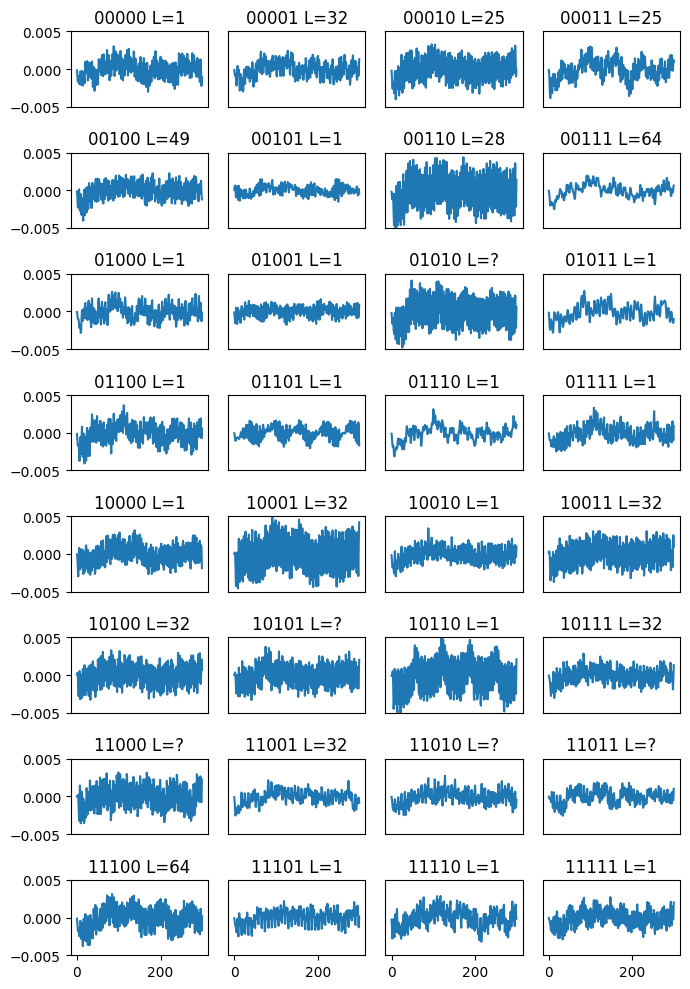

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy import signal

import matplotlib.pyplot as plt
import numpy as np

sos = signal.butter(5, 0.5, "lowpass", output='sos')


fig = plt.figure(0, figsize=(7, 10))
n = 0
for i in range(8):
    for j in range(4):
        ax = plt.subplot2grid((8,4), (i,j))
        ax.plot(signal.sosfilt(sos, traces[n][200:500]))
        ax.set_ylim([-0.005, 0.005])
        
        if i != 7:
            ax.get_xaxis().set_visible(False)
        if j != 0:
            ax.get_yaxis().set_visible(False)
            
        strlen = lengths[n]
        if strlen == -1:
            strlen = "?"
        else:
            strlen = str(strlen)
        ax.set_title('{0:05b} L={1:s}'.format(n, strlen))
        
        n += 1
fig.tight_layout()
plt.show()

The following recreates Figure 3 in my article:

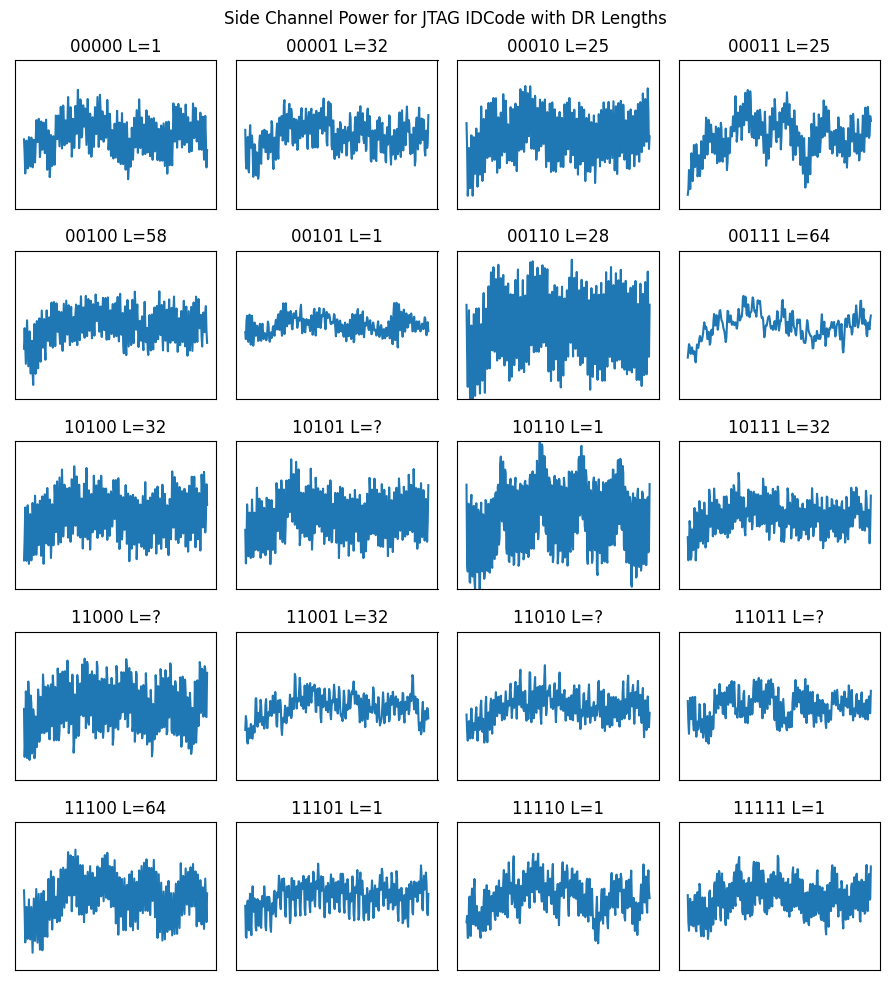

In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy import signal
sos = signal.butter(5, 0.5, "lowpass", output='sos')

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(0, figsize=(9, 10))
plt.suptitle("Side Channel Power for JTAG IDCode with DR Lengths")
n = 0
indexes = [0, 1, 2, 3, 4, 5, 6, 7, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        ax.plot(signal.sosfilt(sos, traces[indexes[n]])[200:500])
        ax.set_ylim([-0.005, 0.005])
        
        #if i != 7:
        ax.get_xaxis().set_visible(False)
        #if j != 0:
        ax.get_yaxis().set_visible(False)
            
        strlen = lengths[indexes[n]]
        if strlen == -1:
            strlen = "?"
        else:
            strlen = str(strlen)
        ax.set_title('{0:05b} L={1:s}'.format(indexes[n], strlen))
        
        n += 1
fig.tight_layout()
#plt.savefig('Figure3.png', dpi=300)
plt.show()